<a href="https://colab.research.google.com/github/Keishin315/Keishin315/blob/main/store_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook provides a recipe for using Kaggle API with Colab

In [304]:
!pip install kaggle

# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [305]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

KeyboardInterrupt: ignored

In [306]:
import csv
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [307]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [308]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         80           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         77           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        808            True  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        141           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1594           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14353            True  
house-pr

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [310]:
!kaggle competitions download -c store-sales-time-series-forecasting

transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stores.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
holidays_events.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
oil.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


# **以下分析✈**

In [311]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

ファイルの読み込み

In [312]:
traincsv = pd.read_csv('train.csv.zip')

datetimeオブジェクトに変換

In [313]:
traincsv.date = pd.to_datetime(traincsv["date"])

ソートして、データセットを作る時のfor文を回せるようにする。

In [314]:
traincsv = traincsv.sort_values(['date','store_nbr','family'])

In [328]:
train = traincsv.set_index('date').drop('id',axis = 1).copy()
train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,54,POULTRY,59.619,0
2017-08-15,54,PREPARED FOODS,94.000,0
2017-08-15,54,PRODUCE,915.371,76


データを変数とラベルに分ける

In [329]:
trainY = train.sales
train = train.drop('sales',axis = 1)

In [330]:
train = np.array(train)
trainY = np.array(trainY)

データセットを作るための関数（５３＊３３で一つのデータセットとする）

In [331]:
#datasetを作る

def make_dataset(data,dataY):
  datasetX = []
  yset = []
  max_length = len(data)
  for i in range(54*33*4,max_length-54*33,54*33):
    datasetX.append(data[i-54*33*4:i,2])
    yset.append(dataY[i:i+54*33])

  return datasetX,yset

  

In [332]:
trainX,trainY = make_dataset(train,trainY)

スケーリングを行い、ネットワークが学習しやすいようにする。

In [333]:
#scaling
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(trainX)  # スケーリングに使用する最小／最大値を計算する。
train = scaler.transform(trainX)  # Xをを0～1の範囲にスケーリングする。

scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(trainY)  # スケーリングに使用する最小／最大値を計算する。
trainY = scaler1.transform(trainY)  # Yをを0～1の範囲にスケーリングする。

LSTMモデルにinputするためにデータの形を整形

In [334]:
trainY = np.array(trainY)
trainX = np.array(trainX)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
print(trainY.shape,trainX.shape)

(1679, 1782) (1679, 1, 7128)


In [337]:
train_X = np.asarray(train_X).astype(np.float32)
train_Y = np.asarray(train_Y).astype(np.float32)

学習データと検証データに分ける

In [336]:
# train, testデータを定義
train_X = trainX[:1000, :, :]
test_X = trainX[1000:, :, :]
train_Y = trainY[:1000, :]
test_Y = trainY[1000:, :]

In [338]:
test_X = np.asarray(test_X).astype(np.float32)
test_Y = np.asarray(test_Y).astype(np.float32)

In [339]:
train_Y

array([[0.2631579 , 0.        , 0.25      , ..., 0.        , 0.        ,
        0.04166667],
       [0.10526316, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08333334, ..., 0.        , 0.        ,
        0.125     ],
       ...,
       [0.05263158, 0.        , 0.25      , ..., 0.209476  , 0.        ,
        0.375     ],
       [0.21052632, 0.        , 0.33333334, ..., 0.25854528, 0.        ,
        0.20833333],
       [0.5263158 , 0.        , 0.33333334, ..., 0.38161317, 0.        ,
        0.125     ]], dtype=float32)

LSTMモデルの定義と学習

In [340]:
model = Sequential()
model.add(LSTM(50, input_shape=(1,7128)))
model.add(Dense(1782))
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(train_X,train_Y,epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1000/1000 - 7s - loss: 0.0133 - 7s/epoch - 7ms/step
Epoch 2/20
1000/1000 - 5s - loss: 0.0087 - 5s/epoch - 5ms/step
Epoch 3/20
1000/1000 - 5s - loss: 0.0084 - 5s/epoch - 5ms/step
Epoch 4/20
1000/1000 - 5s - loss: 0.0082 - 5s/epoch - 5ms/step
Epoch 5/20
1000/1000 - 5s - loss: 0.0082 - 5s/epoch - 5ms/step
Epoch 6/20
1000/1000 - 5s - loss: 0.0081 - 5s/epoch - 5ms/step
Epoch 7/20
1000/1000 - 5s - loss: 0.0081 - 5s/epoch - 5ms/step
Epoch 8/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 9/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 10/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 11/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 12/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 13/20
1000/1000 - 5s - loss: 0.0080 - 5s/epoch - 5ms/step
Epoch 14/20
1000/1000 - 5s - loss: 0.0079 - 5s/epoch - 5ms/step
Epoch 15/20
1000/1000 - 5s - loss: 0.0079 - 5s/epoch - 5ms/step
Epoch 16/20
1000/1000 - 5s - loss: 0.0079 - 5s/ep

検証データの予測

In [341]:
Predict = model.predict(test_X)

In [342]:
Predict.shape

(679, 1782)

スケールを戻す

In [343]:
#scaleを元に戻す
train_Y = scaler1.inverse_transform(train_Y)
train_Y = pd.DataFrame(train_Y)


test_Y = scaler1.inverse_transform(test_Y)
test_Y = pd.DataFrame(test_Y)




In [344]:
Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)


最初の５０個の正解データと予測データを可視化して比較してみる。

In [345]:
import matplotlib.pyplot as plt

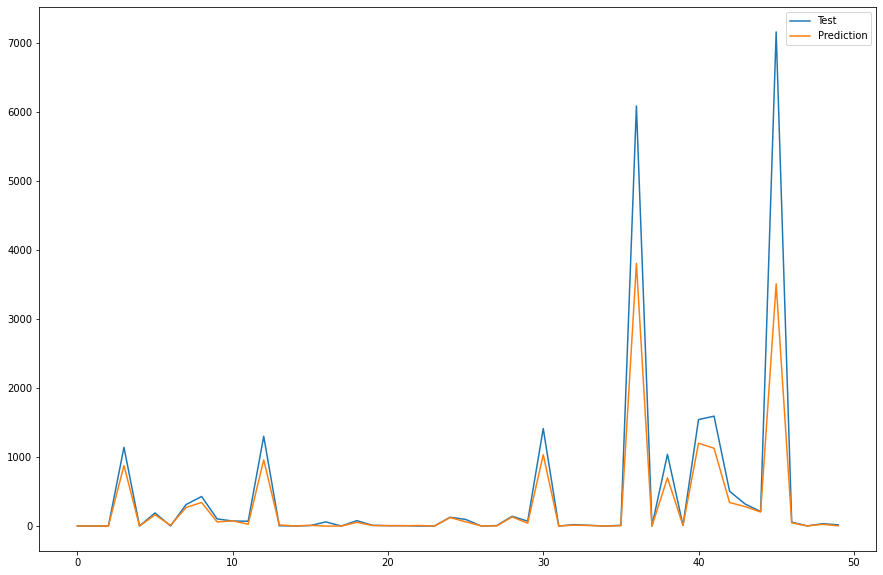

In [346]:
plt.figure(figsize=(15,10))
plt.plot(test_Y.iloc[0,:50], label = 'Test')
plt.plot(Predict.iloc[0,:50], label = 'Prediction')
plt.legend(loc='best')
plt.show()



#





#以下、提出データの作成（とても雑になりました。時間がある時にまたまとめます）


---



In [354]:
test = pd.read_csv('test.csv')

In [355]:
test.date = pd.to_datetime(test.date)

In [356]:
tests = pd.read_csv('test.csv')

In [ ]:
28512 - 5346

23166

In [ ]:
23166/54/33

13.0

In [ ]:
7128/1782

4.0

In [ ]:
54*33

1782

In [357]:
def make_dataset_t(data):
  datasetX = []
  max_length = len(data)
  for i in range(54*33*4,max_length-54*33+1,54*33):
    datasetX.append(data[i-54*33*4:i,1])

  return datasetX

In [358]:

test = test.sort_values(['date','store_nbr','family'])

test = test.set_index('date').drop(['id','family'],axis = 1).copy()

test = np.array(test)
test = make_dataset_t(test)

test = np.array(test)
test = np.asarray(test).astype(np.float32)
#scaling  # データを0～1の範囲にスケールするための関数。
scaler.fit(test)  # スケーリングに使用する最小／最大値を計算する。
test1 = scaler.transform(test)  # Xをを0～1の範囲にスケーリングする。


test1 = np.reshape(test1,(test1.shape[0],1,test1.shape[1]))
print(test1.shape)

(12, 1, 7128)


In [359]:
test1.shape

(12, 1, 7128)

In [360]:
sub = model.predict(test1)

In [361]:
sub.shape

(12, 1782)

In [362]:
1782*16

28512

In [363]:
sub=pd.DataFrame(sub)

In [364]:
sub = scaler1.inverse_transform(sub)

In [365]:
subm = []
for i in sub:
  for k in i:
    subm.append(k)

subm = pd.DataFrame(subm)
subm

,0
0,3.105123
1,-0.003213
2,1.059287
3,1398.899292
4,0.006942
...,...
21379,45.747978
21380,61.840626
21381,386.204529
21382,0.041475


# **ii)**

In [406]:
hosokumi = hosokumi.drop('index',axis = 1)

In [407]:
hosokumi['id'] = pd.DataFrame(list(range(3000888,3029400)))
hosokumi = hosokumi.set_index(['id'])

In [409]:
hosokumi['sales'] = hosokumi.iloc[:,0].copy()

In [410]:
hosokumi = hosokumi.drop(0,axis = 1)

In [411]:
hosokumi

,sales
id,
3000888,3.886041
3000889,4.003090
3000890,4.143873
3000891,4.179241
3000892,-0.001333
...,...
3029395,45.747978
3029396,61.840626
3029397,386.204529


In [412]:
hosokumi.to_csv('pred.csv')

In [413]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f pred.csv -m test

100% 741k/741k [00:01<00:00, 417kB/s]
400 - Bad Request


# **i)**

In [378]:
spe = traincsv.sort_values(['date','store_nbr','family']).drop(['id','sales'],axis = 1).copy()

In [379]:
spe = spe.iloc[-54*33*4:,:]
spe = spe.drop(['store_nbr','family'],axis = 1)

In [380]:
testdash = tests.sort_values(['date','store_nbr','family'])[:54*33*4]

In [381]:
spe = spe.onpromotion.append(testdash.onpromotion)

In [382]:
spe = spe.reset_index()

In [383]:
spe = spe.drop('index',axis = 1)

In [384]:
spe = np.array(spe)

In [392]:
datasetX = []
max_length = len(spe)
for i in range(54*33*4,max_length-54*33+1,54*33):
  datasetX.append(spe[i-54*33*4:i,0])
datasetX

[array([ 0,  0,  1, ..., 76,  0,  0]),
 array([  0,   0,   0, ..., 225,  14,   0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 2, 0, 0])]

In [393]:
datasetX = np.array(datasetX)

In [394]:
scaler.fit(datasetX)  # スケーリングに使用する最小／最大値を計算する。
datasetX = scaler.transform(datasetX)

In [395]:
datasetX.shape

(4, 7128)

In [396]:
datasetX = np.reshape(datasetX,(4,1,54*33*4))
datasetX.shape

(4, 1, 7128)

In [397]:
hosoku = model.predict(datasetX)

In [398]:
hosoku = pd.DataFrame(hosoku)
hosoku = scaler1.inverse_transform(hosoku)

In [399]:
hosoku = pd.DataFrame(hosoku)
hosoku

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781
0,3.886041,-0.001333,2.219401,2032.573120,-0.000768,418.610413,8.143600,771.818237,751.061707,136.383057,158.953781,99.915054,2454.293457,33.839798,1.869568,20.259209,9.582001,0.351770,147.932617,17.500801,12.413411,9.460608,114.784157,2.102675,344.468231,148.655258,5.455626,5.398743,331.600677,96.854118,2692.268555,0.337917,29.709518,5.967448,0.005930,3.404236,2333.261719,0.020456,524.789246,7.750420,...,1.159169,2.612693,139.485138,49.197395,1445.059082,1.149245,4.206088,4.473545,0.086599,0.565718,934.135742,0.001750,204.899551,3.170211,789.860535,139.440430,161.924622,68.030472,24.334999,2038.653564,7.972449,0.506292,14.195752,9.506375,0.185641,138.141724,-0.000335,0.001789,2.787092,28.209297,0.103521,44.094048,136.290573,0.103861,1.596558,46.149334,58.964542,351.396759,0.014864,1.528277
1,4.003090,-0.001779,2.125535,2149.405762,-0.002029,424.319733,9.334998,769.164368,758.016357,140.843872,161.234299,108.143387,2488.014893,33.544853,2.020538,20.545092,10.662827,0.301700,163.902267,18.885439,12.957769,9.642814,119.095161,2.329113,362.031586,150.640839,6.139237,5.897951,341.723969,97.468582,2932.224854,0.358872,30.715494,5.829544,0.008308,3.523955,2509.832764,0.033890,553.461914,8.992963,...,1.305594,3.047790,149.941772,53.789558,1600.991333,1.197345,4.708813,4.664131,0.145825,0.548108,1034.946533,0.002159,207.729614,3.626001,809.869690,137.660980,165.956284,65.505188,23.506598,2074.981201,7.930977,0.442962,15.443693,10.972732,0.189099,159.326828,-0.000942,0.001147,2.437653,28.550907,0.114845,44.401665,140.933975,0.128467,1.758435,45.790798,61.996269,408.898285,0.040890,1.470468
2,4.143873,-0.002734,2.116862,1889.585327,0.006846,408.726837,8.113087,700.615479,708.716858,150.085388,152.234619,94.872536,2304.335205,28.372984,1.990599,17.641485,11.581491,0.307477,133.770111,13.593652,10.011365,8.082395,111.963959,1.877423,374.159821,150.770660,5.469233,3.974858,324.484741,92.017342,1560.817139,0.246250,28.204739,4.702514,0.013174,3.198986,2329.602051,0.036993,578.379883,7.966854,...,1.170403,2.568480,155.093842,55.872658,818.539795,0.410800,5.030066,4.555359,0.235392,0.607269,1057.396362,0.002554,237.165482,3.600786,938.732666,150.166748,195.208939,66.825813,17.251558,2364.816650,8.603275,0.491340,14.819226,12.248070,0.184076,168.594940,-0.001591,-0.000032,2.429203,27.597446,0.078920,52.554455,161.170395,0.084288,1.538936,46.717117,71.403381,466.491455,0.084335,1.181326
3,4.179241,-0.002525,2.071114,2332.103760,-0.003957,422.407898,11.419938,733.768799,762.426941,145.051056,165.608810,121.398636,2495.113281,31.403093,2.334418,20.594015,12.205522,0.227555,185.449081,20.611221,13.007930,9.297134,132.491714,2.651855,377.878632,154.422424,7.313518,6.508517,347.886627,97.809975,3155.502441,0.370323,31.773592,5.889813,0.012225,4.231319,2953.911377,0.049159,616.253784,11.812597,...,1.586771,3.806754,172.405853,61.154678,1801.866211,1.192649,5.719406,5.208638,0.273983,0.548260,1210.288818,0.002568,221.924728,4.779063,902.878723,144.841293,180.358414,64.088524,24.555964,2282.170166,8.371038,0.422024,18.255878,13.664817,0.203079,201.440033,-0.001770,0.000223,2.404669,32.301800,0.151764,46.914288,161.525497,0.178117,2.072539,48.620754,64.064110,506.904053,0.045020,1.341092


In [401]:
hosokum = []
for i in hosoku:
    for k in hosoku[i]:
      hosokum.append(k)


In [402]:
hosokumi = pd.DataFrame(hosokum)

In [403]:
hosokumi = hosokumi.append(subm)

In [404]:
hosokumi = hosokumi.reset_index()

In [405]:
hosokumi


,index,0
0,0,3.886041
1,1,4.003090
2,2,4.143873
3,3,4.179241
4,4,-0.001333
...,...,...
28507,21379,45.747978
28508,21380,61.840626
28509,21381,386.204529
28510,21382,0.041475
